In [236]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv

In [429]:
# Read csv file
cases = pd.read_csv('../STA 141C/Cases_Subset.csv', sep = ",", dtype = "str")

In [430]:
# Drop extra columns
cases = cases.drop(cases.columns[range(20,47)], axis = 1)
cases[date_columns] = cases[date_columns].apply(pd.to_datetime, format = "%m/%d/%Y %I:%M:%S %p",errors = "coerce")

In [431]:
# Question 3: given the request type, what is the predicted time of day

# subset data
cases_q3 = cases.drop(['Request Details','CaseID','Media URL','Closed','Updated',
                       'Status Notes','Point','Address'], axis=1)
cases_q3 = cases_q3.dropna()

In [432]:
# separate by day and night 
# day = 0; night = 1
cases_q3 = cases_q3.set_index(pd.to_datetime(cases_q3['Opened']))
cases_q3["day_night"] = 1

In [433]:
cases_q3.loc[cases_q3.between_time("06:00", "18:00").index, "day_night"] = 0

In [434]:
cases_q3["day_night"].value_counts()

0    1459
1     455
Name: day_night, dtype: int64

In [435]:
# dummy variables for categorical columns
status = pd.get_dummies(cases_q3['Status'],drop_first=True)
category = pd.get_dummies(cases_q3['Category'],drop_first=True)
request = pd.get_dummies(cases_q3['Request Type'],drop_first=True)
agency = pd.get_dummies(cases_q3['Responsible Agency'],drop_first=True)
street = pd.get_dummies(cases_q3['Street'],drop_first=True)
supervisor = pd.get_dummies(cases_q3['Supervisor District'],drop_first=True)
neighbor = pd.get_dummies(cases_q3['Neighborhood'],drop_first=True)
police = pd.get_dummies(cases_q3['Police District'],drop_first=True)
source = pd.get_dummies(cases_q3['Source'],drop_first=True)

In [436]:
df_cases = pd.concat([cases_q3,status,category,request,agency,street,supervisor,neighbor,police,source],axis=1)

In [437]:
# dropping the original columns
df_cases = df_cases.drop(['Status','Category','Request Type','Responsible Agency','Street',
              'Supervisor District','Neighborhood','Police District',
              'Opened','Source'],axis=1)

In [400]:
# Dimension Reduction & Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [401]:
X = df_cases.loc[:,df_cases.columns != 'day_night']

# create y from rating
y = df_cases['day_night']

## Logistic Regression After PCA

In [402]:
# PCA the data except day_night column
from sklearn.decomposition import PCA
pca = PCA(n_components=2,random_state=1)
pca_data = pca.fit_transform(df_cases.loc[:,df_cases.columns != 'day_night'])

In [403]:
# split the data into test and training sets, with 70% of samples being put into the training set
X_train, X_test, y_train, y_test = train_test_split(pca_data, y, test_size=0.3, random_state=0)

In [404]:
# Logistic Regression after PCA
clf = LogisticRegression(penalty='l2', solver='liblinear')
clf.fit(X_train, y_train)
print('Coefficient of each feature:', clf.coef_)
print('Training accuracy:', clf.score(X_train, y_train))
print('Test accuracy:', clf.score(X_test, y_test))
print('')

Coefficient of each feature: [[-0.00098988 -0.23490749]]
Training accuracy: 0.7628571428571429
Test accuracy: 0.765



In [405]:
# accuracy 
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score

y_predict = clf.predict(X_test) 

print("Confusion Matrix")
print(confusion_matrix(y_test, y_predict))
print()

Confusion Matrix
[[459   0]
 [141   0]]



In [344]:
print("Accuracy Score:",accuracy_score(y_test, y_predict))
print()

Accuracy Score: 0.768695652173913



## Logistic Regression With Original Dataset

In [356]:
# split the data into test and training sets, with 70% of samples being put into the training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [346]:
# Logistic Regression after PCA
clf = LogisticRegression(penalty='l2', solver='liblinear')
clf.fit(X_train, y_train)
print('Training accuracy:', clf.score(X_train, y_train))
print('Test accuracy:', clf.score(X_test, y_test))
print('')

Training accuracy: 0.8543689320388349
Test accuracy: 0.7704347826086957



In [347]:
# try to predict the last entry after training all others
X_pred = df_cases.iloc[:-1, df_cases.columns != 'day_night']
y_pred = df_cases.iloc[:-1,-1]

In [348]:
clf.fit(X_pred, y_pred)

# if the request was made during the day or night time
pred = clf.predict(np.array(df_cases.iloc[-1, df_cases.columns != 'day_night']).reshape(1,-1))

In [349]:
# check the prediction
pred 

array([0], dtype=uint8)

In [358]:
# accuracy 

y_predict = clf.predict(X_test) 

print("Confusion Matrix")
print(confusion_matrix(y_test, y_predict))
print()

Confusion Matrix
[[388  54]
 [115  18]]



In [311]:
print("Accuracy Score:",accuracy_score(y_test, y_predict))
print()

Accuracy Score: 0.7060869565217391



In [312]:
# Question 4
cars = cases['Request Details'].str.split('-').str[1]

In [313]:
# separating car brands by price levels
high = ['BMW','Mercedes','Audi','Tesla','Porsche','Ferrari','Land Rover',
        'Lamborghini','Maserati','Jaguar','Cadillac']
med = ['Acura','Lexus','Mini','Infiniti','Volvo']
low = ['Honda','Kia','Toyota','Hyundai','Ford','Nissan','Chevrolet',
       'Volkswagon','VW','Jeep','Mazda','Subaru']

In [314]:
# new dataframe with request type and car brands extracted from request details column
df_cars = pd.concat([cars,cases['Request Type']],axis=1).dropna()

In [315]:
req = df_cars['Request Details']

In [316]:
# labeling appropriate price levels for requests based on car brands
df_cars.loc[req.str.contains('|'.join(high)),'Price Level'] = 'High'
df_cars.loc[req.str.contains('|'.join(med)),'Price Level'] = 'Medium'
df_cars.loc[req.str.contains('|'.join(low)),'Price Level'] = 'Low'

In [317]:
# final cleaned dataset
data_cars = df_cars.dropna().reset_index(drop=True)

In [318]:
# trying to see if there's a relationship between price level and request type
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer()
tfidf = tf_idf.fit_transform(data_cars['Request Type']).toarray()

In [319]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2,random_state=1)
tfidf_pca = pca.fit_transform(tfidf)

In [320]:
high = data_cars.index[data_cars['Price Level'] == 'High']
med = data_cars.index[data_cars['Price Level'] == 'Medium']
low = data_cars.index[data_cars['Price Level'] == 'Low']

In [321]:
# separate by price level and cluster request type
from collections import Counter
# density of request type by high priced cars
# density is shown by the size of the points
x = tfidf_pca[high,0]
y = tfidf_pca[high,1]
c = Counter(zip(x,y)) # count same points
s = [c[(xx,yy)] for xx,yy in zip(x,y)] # scale

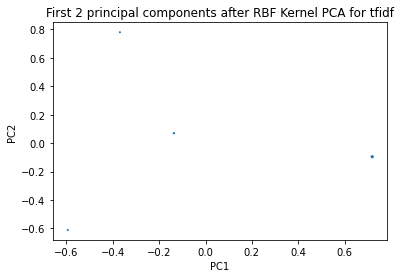

In [322]:
plt.scatter(x, y, s=s)
plt.title('First 2 principal components after RBF Kernel PCA for tfidf')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [323]:
# merge kpca and data_cars by price level (high)
x_coord = c.most_common(1)[0][0][0]
y_coord = c.most_common(1)[0][0][1]

car_index = np.where((tfidf_pca[high,0] == x_coord) & (tfidf_pca[high,1] == y_coord))

In [324]:
# request type with the highest count
high_car = data_cars.loc[data_cars['Price Level'] == 'High']
high_car.reset_index(drop=True, inplace=True)
high_car.loc[(car_index[0][0]), data_cars.columns == 'Request Type']

Request Type    Other_Illegal_Parking
Name: 1, dtype: object

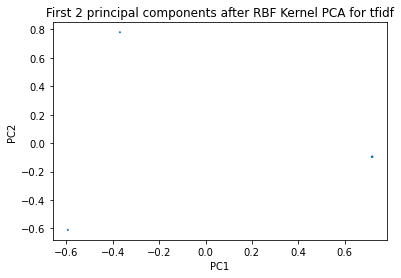

In [325]:
# density of request type by medium priced cars
x = tfidf_pca[med,0]
y = tfidf_pca[med,1]
c = Counter(zip(x,y))
s = [c[(xx,yy)] for xx,yy in zip(x,y)]

plt.scatter(x, y, s=s)
plt.title('First 2 principal components after RBF Kernel PCA for tfidf')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [326]:
# merge kpca and data_cars by price level (med)
x_coord = c.most_common(1)[0][0][0]
y_coord = c.most_common(1)[0][0][1]

car_index = np.where((tfidf_pca[med,0] == x_coord) & (tfidf_pca[med,1] == y_coord))

In [327]:
# request type with the highest count
med_car = data_cars.loc[data_cars['Price Level'] == 'Medium']
med_car.reset_index(drop=True, inplace=True)
med_car.loc[(car_index[0][0]), data_cars.columns == 'Request Type']

Request Type    Other_Illegal_Parking
Name: 0, dtype: object

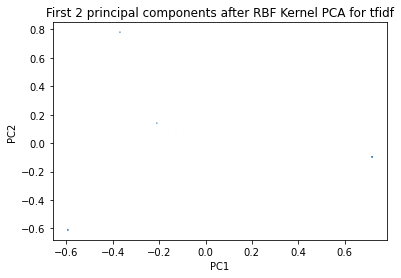

In [328]:
# density of request type by low priced cars
x = tfidf_pca[low,0]
y = tfidf_pca[low,1]
c = Counter(zip(x,y))
s = [0.001*c[(xx,yy)] for xx,yy in zip(x,y)] # change multiplier 

plt.scatter(x, y, s=s)
plt.title('First 2 principal components after RBF Kernel PCA for tfidf')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [329]:
# merge kpca and data_cars by price level (low)
x_coord = c.most_common(1)[0][0][0]
y_coord = c.most_common(1)[0][0][1]

car_index = np.where((tfidf_pca[low,0] == x_coord) & (tfidf_pca[low,1] == y_coord))

In [330]:
# request type with the highest count
low_car = data_cars.loc[data_cars['Price Level'] == 'Low']
low_car.reset_index(drop=True, inplace=True)
low_car.loc[(car_index[0][0]), data_cars.columns == 'Request Type']

Request Type    Other_Illegal_Parking
Name: 6, dtype: object

In [511]:
# Question 7: common attributes for NA rows
cases = pd.read_csv('../STA 141C/Cases_Subset.csv', sep = ",", dtype = "str")

cases = cases.drop(cases.columns[range(20,47)], axis = 1)

In [512]:
cases = cases[cases['Closed'].isna()]

In [513]:
cases_q7 = cases.drop(['Request Details','CaseID','Media URL','Closed','Updated',
                       'Status Notes','Point','Address'], axis=1)

In [514]:
# dummy variables for categorical columns
status = pd.get_dummies(cases_q7['Status'],drop_first=True)
category = pd.get_dummies(cases_q7['Category'],drop_first=True)
agency = pd.get_dummies(cases_q7['Responsible Agency'],drop_first=True)
street = pd.get_dummies(cases_q7['Street'],drop_first=True)
supervisor = pd.get_dummies(cases_q7['Supervisor District'],drop_first=True)
neighbor = pd.get_dummies(cases_q7['Neighborhood'],drop_first=True)
police = pd.get_dummies(cases_q7['Police District'],drop_first=True)
source = pd.get_dummies(cases_q7['Source'],drop_first=True)

In [515]:
df7_cases = pd.concat([cases_q7,status,category,agency,street,supervisor,neighbor,police,source],axis=1)

In [516]:
# dropping the original columns
df7_cases = df7_cases.drop(['Status','Category','Responsible Agency','Street',
              'Supervisor District','Neighborhood','Police District',
              'Opened','Source'],axis=1)

In [495]:
X = df7_cases.loc[:,df7_cases.columns != 'Request Type']

# create y from rating
y = df7_cases['Request Type']

In [503]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x = sc.fit_transform(X)
pca_q7 = pca.fit_transform(x)
principalDf = pd.DataFrame(data = pca_q7,
                           columns = ['principal component 1', 'principal component 2'])
principalDf.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
finalDf = pd.concat([principalDf, y], axis=1)

In [555]:
# plotting seven most common request types
na_data = df7_cases.groupby('Request Type').agg('count')['Latitude'].sort_values(ascending=False).head(7)

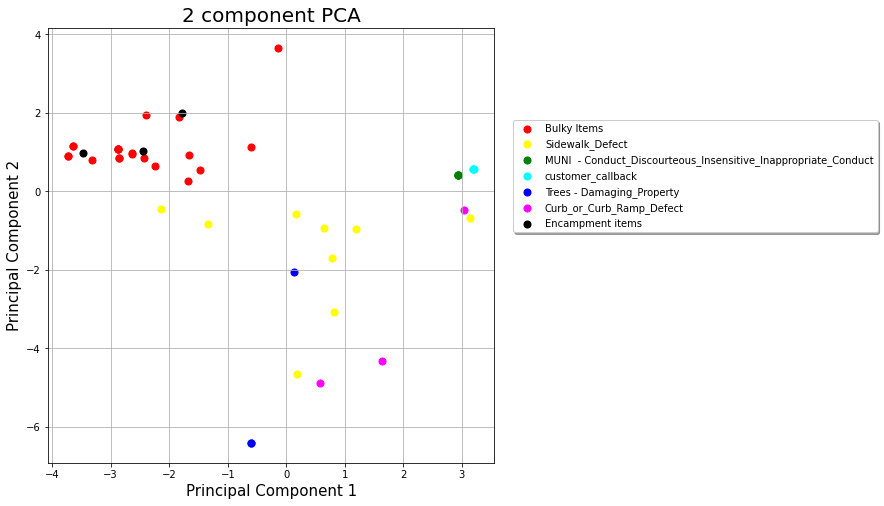

In [560]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = list(na_data.index) # target values
colors = ['red', 'yellow', 'green', 'cyan', 'blue', 'magenta','black']

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Request Type'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets,loc = 'upper center',bbox_to_anchor = (1.45, 0.8), shadow = True, ncol = 1)
ax.grid()